In [1]:
!pip install --upgrade tensorflow


    100% |████████████████████████████████| 48.0MB 28kB/s 
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 3.1MB 445kB/s 
Requirement already up-to-date: numpy>=1.13.3 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 6.4MB 214kB/s 
Requirement already up-to-date: absl-py>=0.1.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 51kB 10.8MB/s 
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
    100% |████████████████████████████████| 7.7MB 179kB/s 
Requirement already up-to-date: werkzeug>=0.11.10 in /usr/local/lib/py

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
print(tf.VERSION)

1.7.0


In [3]:
# __future__ : It can be used to use features which will appear in newer versions while having an older release of Python.
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe



print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: True


In [4]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
# tf.keras.utils.get_file() downloads the dataset and returns the local path of the downloaded file
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),origin=train_dataset_url)
print("Local copy of the dataset fil: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset fil: /content/.keras/datasets/iris_training.csv


In [5]:
!head {train_dataset_fp} # by default prints the first 10 lines
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0
5.7,3.8,1.7,0.3,0
4.4,3.2,1.3,0.2,0
5.4,3.4,1.5,0.4,0
6.9,3.1,5.1,2.3,2
6.7,3.1,4.4,1.4,1
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [0]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]
  # decode_csv Converts CSV records to tensors. Each column maps to one tensor.
  parse_line = tf.decode_csv(line,example_defaults)
  features = tf.reshape(parse_line[:-1],shape=(4,))
  label = tf.reshape(parse_line[-1],shape=())
  return features, label

In [7]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)
# The difference is that map will execute one function on every element of the Dataset separately
# whereas apply will execute one function on the whole Dataset at once 
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(32)
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label",label[0])


example features: tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float32)
example label tf.Tensor(0, shape=(), dtype=int32)


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(3)
])

In [0]:
def loss(model,x,y):
  y_=model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y,logits=y_)

def grad(model,inputs,targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model,inputs,targets)
  return tape.gradient(loss_value,model.variables)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [11]:
train_loss_results = []
train_accuracy_results = []
num_epochs = 201
for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  for x,y in tfe.Iterator(train_dataset):
    #print("x and y are",x," ",y) # x and y are for minibatch of 32 examples/observations
    # above line prints the first 32 rows of dataset since our batch by default is 32
    grads = grad(model, x, y)
    #print("model variables are",model.variables) # prints weights of each layer
    # this prints all the weights, bias of each layer, very informative
    # weights were given some random values and bias are all set to 0 in first iteration
    optimizer.apply_gradients(zip(grads,model.variables),
                             global_step=tf.train.get_or_create_global_step())
    epoch_loss_avg(loss(model,x,y))
    epoch_accuracy(tf.argmax(model(x),axis=1,output_type=tf.int32),y)
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  if epoch % 50 == 0 :
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                               epoch_loss_avg.result(),
                                                               epoch_accuracy.result()))

Epoch 000: Loss: 1.326, Accuracy: 15.000%
Epoch 050: Loss: 0.463, Accuracy: 79.167%
Epoch 100: Loss: 0.284, Accuracy: 96.667%
Epoch 150: Loss: 0.189, Accuracy: 97.500%
Epoch 200: Loss: 0.134, Accuracy: 97.500%


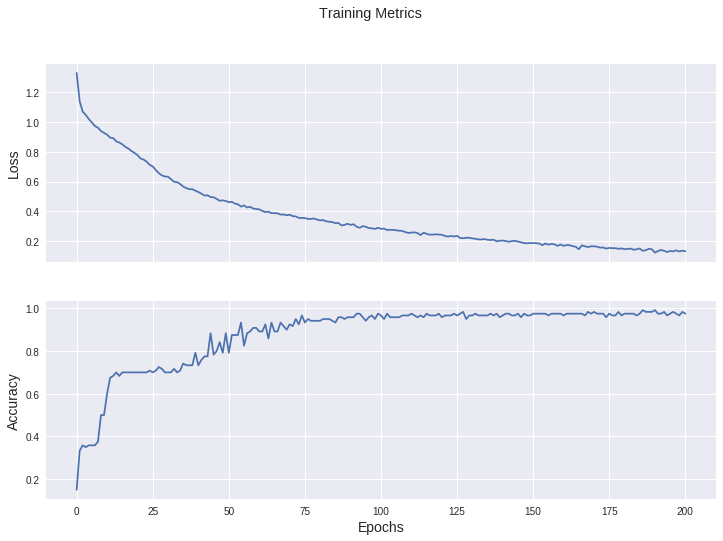

In [25]:
fig, axes = plt.subplots(2, sharex = True, figsize=(12,8)) # this generates two plots, one below the other, the x axis is shared which means, x axis is marked and labelled as a common axis
fig.suptitle('Training Metrics') #suptitle sets the title for the whole plot, since we have multiple plots here
# You can set the main figure title with fig.suptitle and subplot's titles with ax.set_title or by passing title to fig.add_subplot
axes[0].set_ylabel("Loss",fontsize=14)
# we created 2 subplots here. axes[0] refers the first plot and axes[1] refers to second plot
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs",fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


In [0]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),origin=test_url)
# fname: Name of the file. If an absolute path `/path/to/file.txt` is specified the file will be saved at that location.
'''
Both functions use the os.path.split(path) function to split the pathname path into a pair; (head, tail).

The os.path.dirname(path) function returns the head of the path.

E.g.: The dirname of '/foo/bar/item' is '/foo/bar'.

The os.path.basename(path) function returns the tail of the path.

E.g.: The basename of '/foo/bar/item' returns 'item'
'''
test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

In [35]:
test_accuracy = tfe.metrics.Accuracy()

test_index = 1
for x,y in tfe.Iterator(test_dataset):
  if test_index == 1:
    print(model(x))
  prediction = tf.argmax(model(x), axis=1,output_type=tf.int32)
  test_accuracy(prediction,y)
  test_index = 2
  
print("Test set accuracy: {:.3f}".format(test_accuracy.result()))
  
  

tf.Tensor(
[[-2.8576448   2.3912346   0.7262622 ]
 [-2.6979403   1.9306469   0.94867074]
 [ 4.3383217   0.2005519  -7.974553  ]
 [ 4.961014    0.06784573 -8.862272  ]
 [-0.5387735   1.7141184  -2.216999  ]
 [ 4.454423    0.26464596 -8.305475  ]
 [-2.180199    2.1200078  -0.12100235]
 [-6.440628    2.814172    6.3105946 ]
 [-5.3056364   2.6657798   4.571819  ]
 [-1.9612067   2.1325026  -0.77302706]
 [-5.0727243   2.6129606   3.9779456 ]
 [-1.6824216   1.9637693  -0.8410841 ]
 [-3.2668395   2.3095102   1.64351   ]
 [ 4.405816    0.15052167 -8.019054  ]
 [-5.817508    2.762578    5.044322  ]
 [-5.6934342   2.6074157   5.0778017 ]
 [-5.5910425   2.3839808   5.5506535 ]
 [ 4.1224413   0.38856283 -7.7689114 ]
 [-2.5732887   2.1731014   0.4213055 ]
 [-1.6841146   1.8510852  -0.9062389 ]
 [-2.1460443   2.1532705  -0.4579927 ]
 [-2.7125518   2.3319619   0.17792186]
 [-3.9030647   2.4341779   2.3092086 ]
 [ 4.803511    0.09071007 -8.57335   ]
 [ 3.8624406   0.0706009  -6.9031534 ]
 [-2.5207558  

In [38]:
test_dataset

<BatchDataset shapes: ((?, 4), (?,)), types: (tf.float32, tf.int32)>